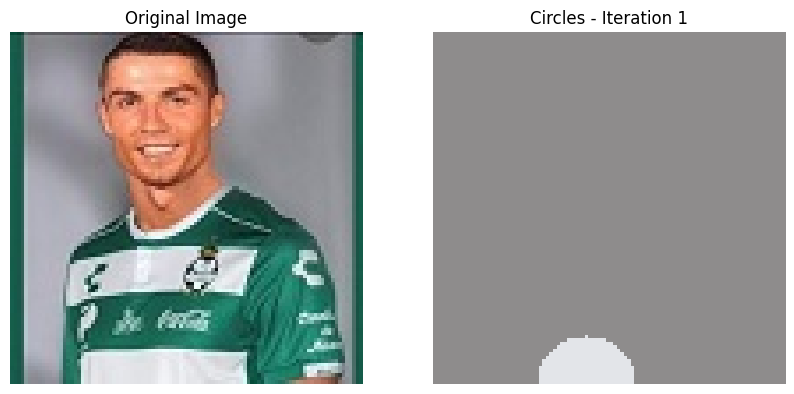

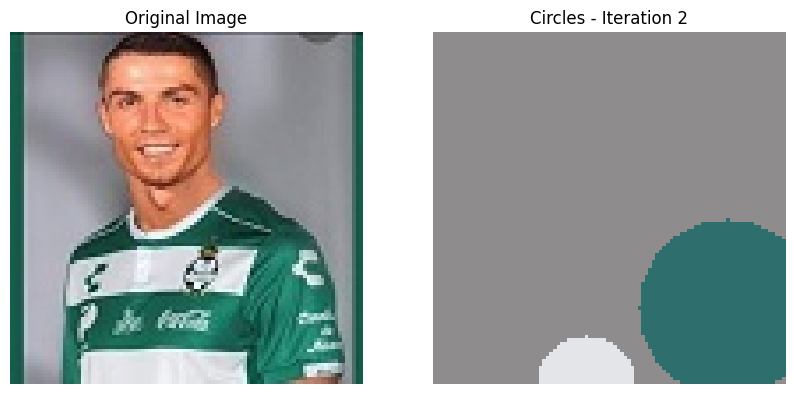

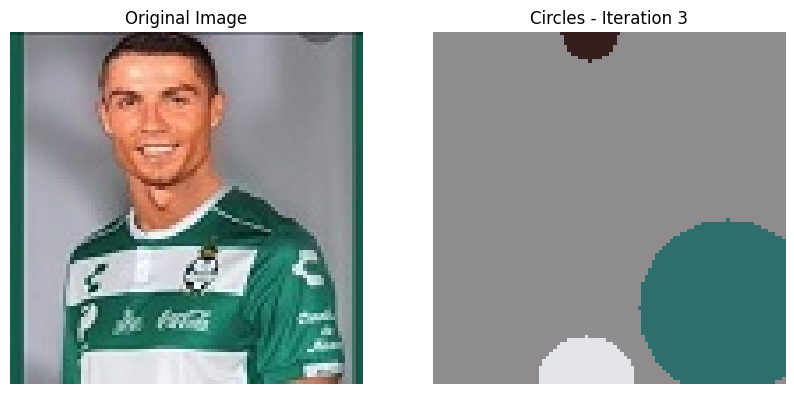

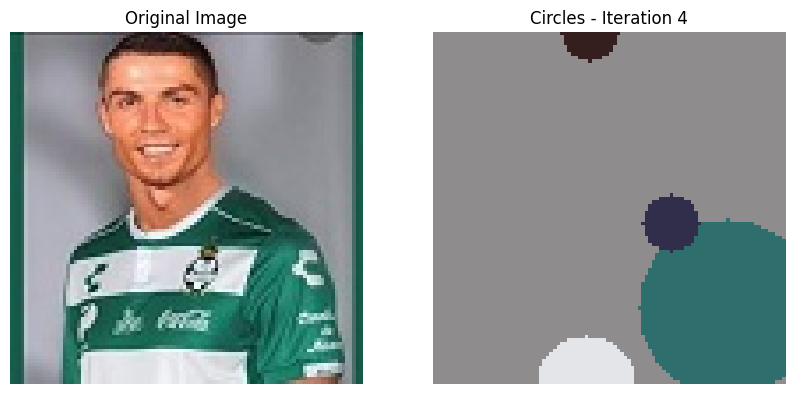

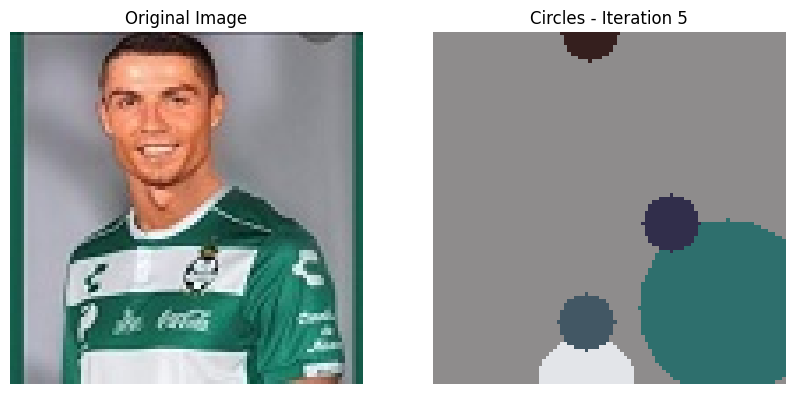

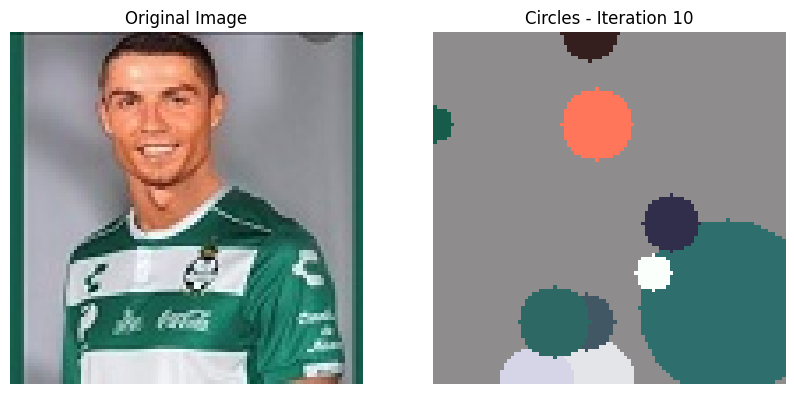

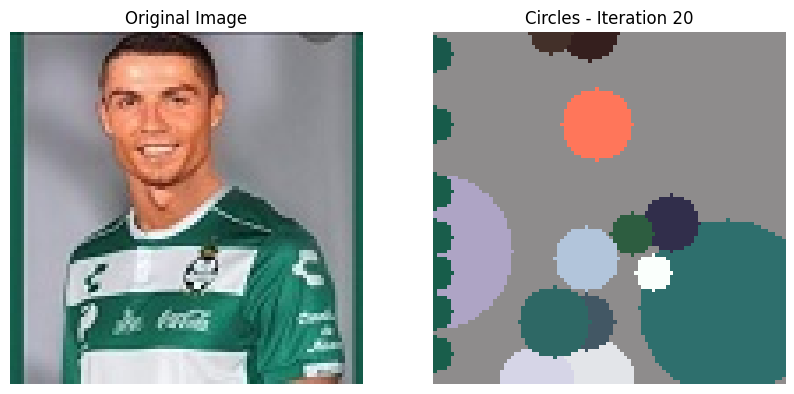

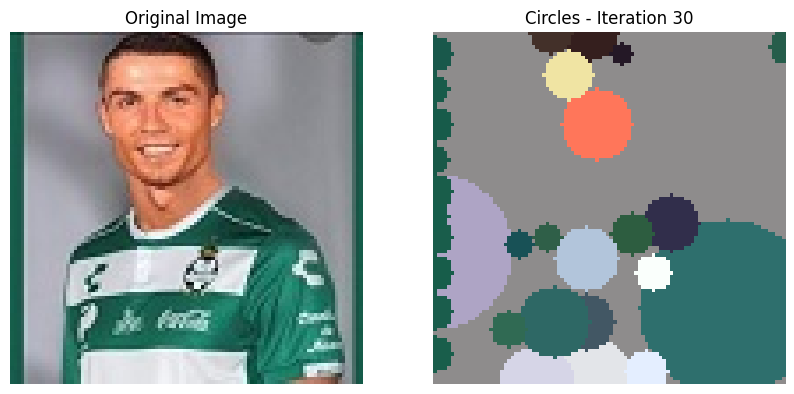

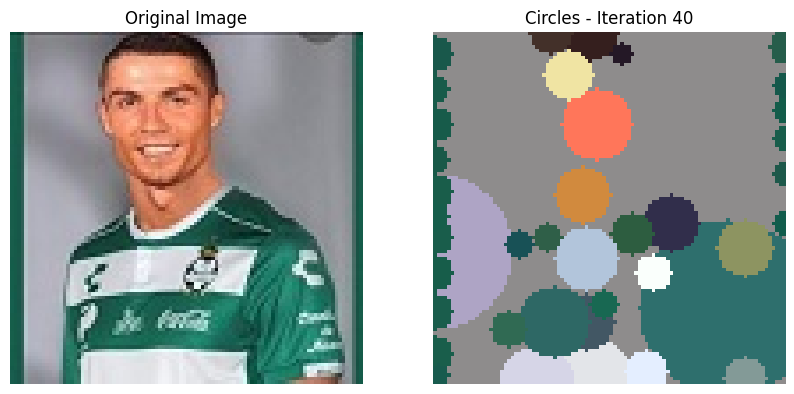

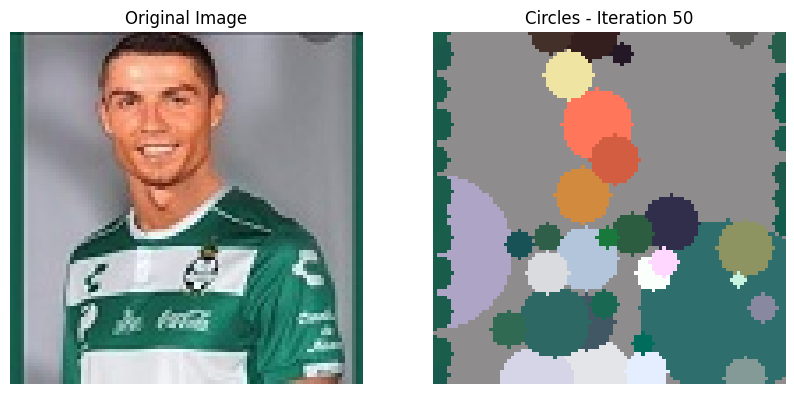

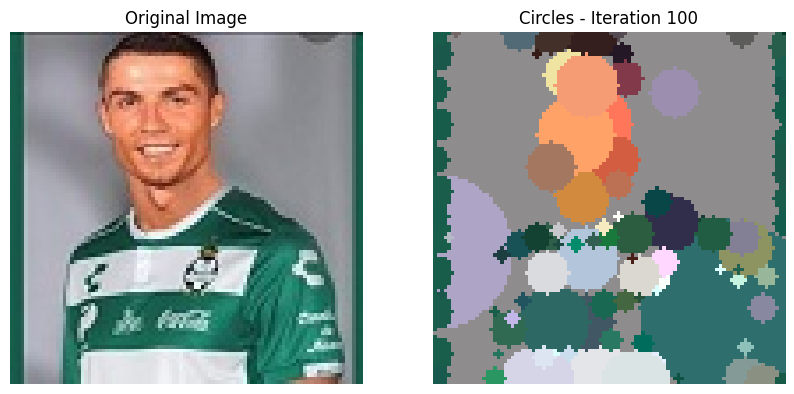

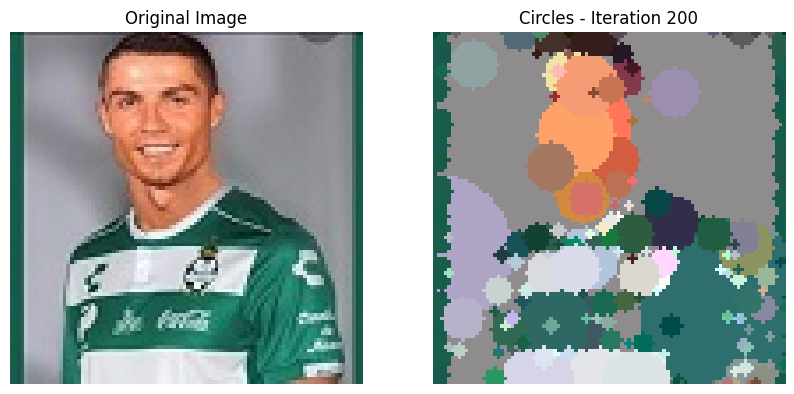

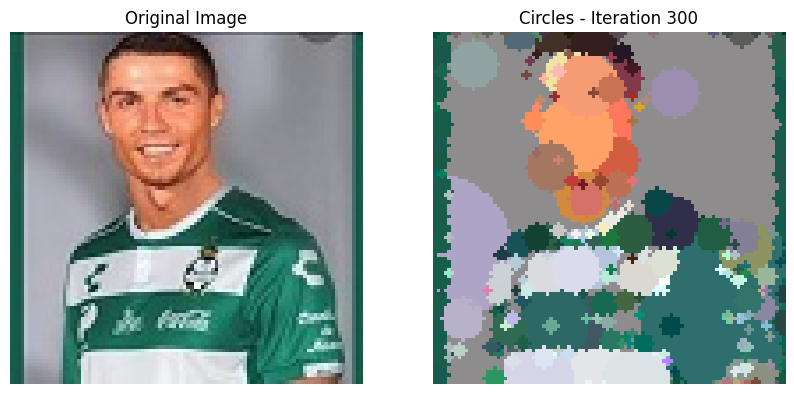

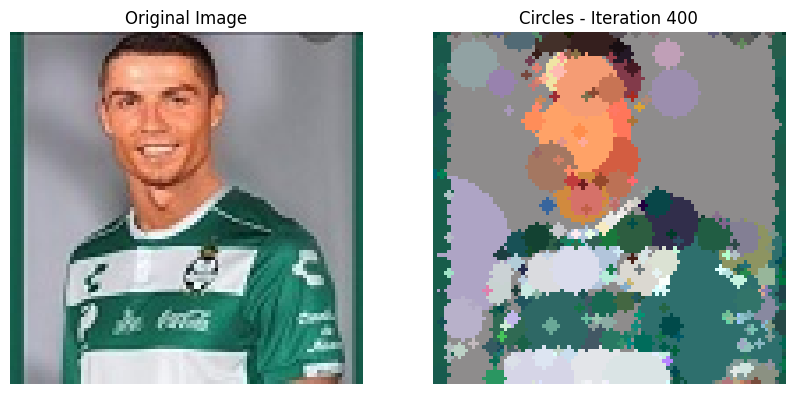

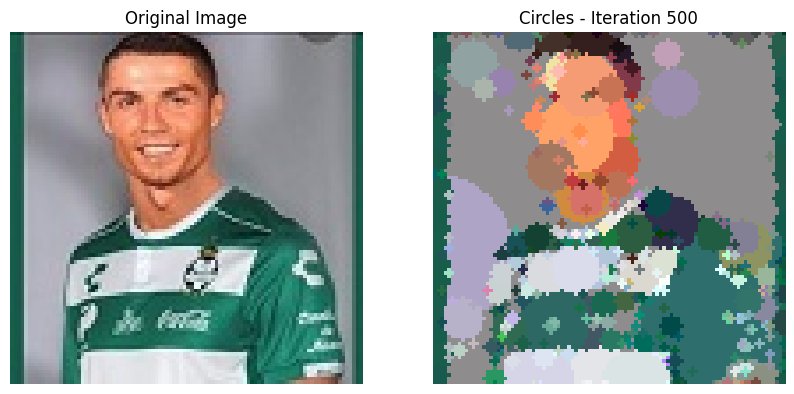

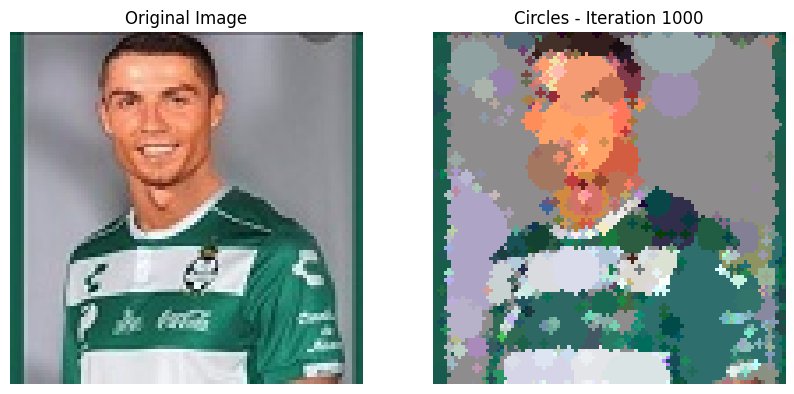

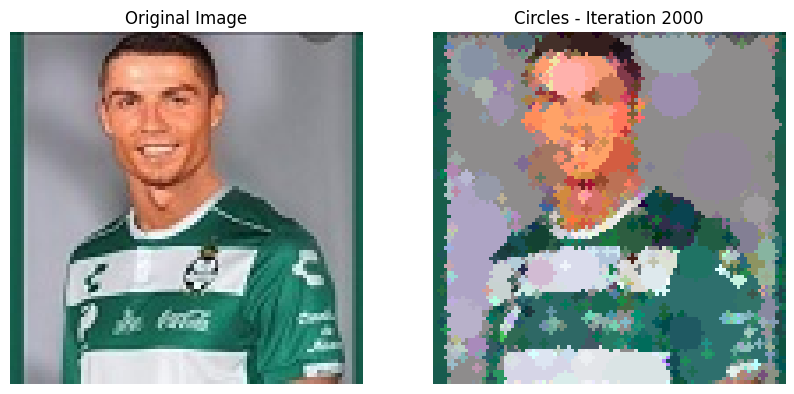

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2 as cv

def error(p, X, y):
    A, B, C, D = p
    Yp = A * np.sin(B * X + C) + D
    return np.linalg.norm(Yp - y)

bounds = np.array([[-100, 100], [-100, 100], [-100, 100], [-100, 100]])

class DifferentialEvolution:
    def __init__(self, func, bounds, args=None, popsize=100, recombination=0.7, stopValue=0.0001):
        self.func = func
        self.bounds = bounds
        self.args = args
        self.popsize = popsize
        self.recombination = recombination
        self.nDimension = len(bounds)
        self.population = np.zeros((self.popsize, self.nDimension))
        self.fitness = np.zeros((self.popsize))
        self.stopValue = stopValue
        self.ui = np.zeros((self.nDimension))
        self.uiFitness = None

    def initPopulation(self):
        for d in range(self.nDimension):
            self.population[:, d] = np.random.uniform(self.bounds[d, 0], self.bounds[d, 1], self.popsize)
        for i in range(self.popsize):
            self.fitness[i] = self.func(self.population[i, :], *self.args)

    def mutation(self):
        r1, r2, r3 = np.random.choice(self.popsize, 3, replace=False)
        u = np.random.uniform(0.5, 2)
        vi = self.population[r1] + u * (self.population[r2] - self.population[r3])

        # Restringir el vector mutado a los límites
        for j in range(self.nDimension):
            vi[j] = np.clip(vi[j], self.bounds[j, 0], self.bounds[j, 1])

        return vi

    def crossover(self, xi, vi):
        k = np.random.randint(self.nDimension)
        self.ui[k] = vi[k]
        for i in range(self.nDimension):
            if i == k:
                continue
            r = np.random.random()
            if r <= self.recombination:
                self.ui[i] = vi[i]
            else:
                self.ui[i] = xi[i]

        # Restringir el vector recombinado a los límites
        for j in range(self.nDimension):
            self.ui[j] = np.clip(self.ui[j], self.bounds[j, 0], self.bounds[j, 1])

    def selection(self, xi, i, ui):
        self.uiFitness = self.func(ui, *self.args)
        if self.fitness[i] > self.uiFitness:
            self.population[i] = ui.copy()  # Asegúrate de hacer una copia
            self.fitness[i] = self.uiFitness

    def optimize(self):
        self.initPopulation()
        for ng in range(100):
            for i in range(self.popsize):
                vi = self.mutation()
                self.crossover(self.population[i], vi)
                self.selection(self.population[i], i, self.ui)
                if self.fitness[i] <= self.stopValue:
                    return (self.fitness[i], self.population[i])
        b = np.argmin(self.fitness)
        return (self.fitness[b], self.population[b])

def differential_evolution_own(func, bounds, args, popsize = 50, recombination = 0.7):
    de = DifferentialEvolution(func, bounds, args, popsize, recombination)
    return de.optimize

imgPath = '/content/bicho.jpg'
imgOriginal = cv.imread(imgPath)

def fitness(circle, imgOriginal, imgBase):
    newBase = copy.deepcopy(imgBase)
    x, y, radio, R, G, B = circle
    x = int(x)
    y = int(y)
    radio = int(radio)
    B, G, R = int(B), int(G), int(R)
    cv.circle(newBase, (x, y), radio, (B, G, R), thickness = -1)
    dif = cv.absdiff(imgOriginal, newBase)
    return np.sum(dif)

def imageWithCircles(imgOriginal):
    h, w = imgOriginal.shape[:2]
    toPrint = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]
    bounds = np.array([[0, h], [0, w], [1, max(h, w)], [0, 255], [0, 255], [0, 255]])
    imgBase = np.ones_like(imgOriginal, dtype='uint8') * 255

    for nc in range(2001):
        de = DifferentialEvolution(fitness, bounds, args=(imgOriginal, imgBase), popsize=100, recombination=0.7)
        res = de.optimize()
        x, y, radio, R, G, B = res[1]
        cv.circle(imgBase, (int(x), int(y)), int(radio), (int(B), int(G), int(R)), thickness=-1)

        if nc in toPrint:
            plt.figure(figsize=(10, 5))

            #imagen original
            plt.subplot(1, 2, 1)
            plt.imshow(cv.cvtColor(imgOriginal, cv.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')

            #imagen gener
            plt.subplot(1, 2, 2)
            plt.imshow(cv.cvtColor(imgBase, cv.COLOR_BGR2RGB))
            plt.title(f"Circles - Iteration {nc}")
            plt.axis('off')

            plt.show()

imageWithCircles(imgOriginal)
